In [29]:
from main import *

In [2]:
train_df_original = pd.read_csv('../data/train.csv')
train_df = train_df_original.copy()
test_df_original = pd.read_csv('../data/test.csv')
test_df = test_df_original.copy()

Limpiamos los datos que molestan y agregamos los features engenieres que vamos a usar

In [3]:
drops(train_df)
train_df = feats.newfeats(train_df)
# Separamos un 2% para utilizar en las predicciones
df_train, df_test = train_test_split(train_df, test_size=0.2, random_state=1)

In [4]:
def print_scores_por_segmento(model):
    scores = np.array(model.scores_por_segmento())
    df_scores = pd.DataFrame()
    i = 0
    for metric in model.metrics():
        df_scores[metric.__name__] = scores[:, i]
        i += 1
    return df_scores

In [5]:
def print_scores_promedio(model):
    df_prom_scores = pd.DataFrame()
    prom_scores = np.array(model.prom_scores())
    i = 0
    for metric in model.metrics():
        df_prom_scores[metric.__name__] = [prom_scores[i]]
        i += 1

    return df_prom_scores

# Modelos sin NLP

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

model1 = Model(df_train, features=['metroscubiertos', 'metrostotales', 'banos'], segment_columns=['provincia'])
model1.regresionar()
model2 = Model(df_train, features=['metroscubiertos', 'metrostotales', 'mejorciudad'], segment_columns=['provincia'])
model2.regresionar();
model3 = Model(df_train, features=['metroscubiertos', 'metrostotales', 'banos'], segment_columns=['urbana', 'calurosa'])
model3.regresionar();

# Modelos con NLP

In [ ]:
nlpModel = NlpModel(train_df, text_features=['titulo', 'descripcion'], features=['metroscubiertos', 'mejorciudad'], segment_columns=['urbana', 'banos'])
segments_ret = nlpModel.regresionar()

In [ ]:
nlpModel2 = NlpModel(train_df, text_features=['titulo', 'descripcion'], features=['metroscubiertos', 'metrostotales', 'banos'], segment_columns=['provincia'])
segments_ret = nlpModel2.regresionar()

## Resumen de resultados

In [10]:
scores_model1 = print_scores_promedio(model1)
scores_model1['name'] = 'model1'
scores_model2 = print_scores_promedio(model2)
scores_model2['name'] = 'model2'

scores_model3 = print_scores_promedio(model3)
scores_model3['name'] = 'model3'

scores_modelnlp = print_scores_promedio(nlpModel)
scores_modelnlp['name'] = 'nlpModel'

scores_modelnlp2 = print_scores_promedio(nlpModel2)
scores_modelnlp2['name'] = 'nlpModel2'

scores_vs_models = pd.concat([scores_model1, scores_model2, scores_model3, scores_modelnlp, scores_modelnlp2])

In [11]:
scores_vs_models

,mean_squared_error,mean_squared_log_error,r2_score,max_error,NRMSE,mean_absolute_error,porcentajeProm,name
0,783557096384.816,0.346,0.169,3042746.479,494953.719,652917.067,69.454,model1
0,1131002886553.449,0.364,0.033,3116271.508,627524.612,683193.593,66.936,model2
0,2340202131425.650,0.392,0.265,8608062.316,985175.039,1147591.972,70.990,model3
0,1786257573862.098,0.192,0.189,4602750.933,541684.561,855486.454,41.076,nlpModel
0,951248550876.250,0.383,0.317,3127301.951,545685.616,765342.483,76.960,nlpModel2


## Model 1 vs Model 2

In [25]:
from feats import newfeats
order_df = df_test.copy()
order_df = order_df[:100]
order_df = order_df.sort_values('precio')

order_df = order_df[['metroscubiertos', 'metrostotales', 'provincia', 'banos', 'mejorciudad', 'precio']].dropna()
reales = order_df['precio']
pred_mod1 = model1.predict(order_df)
pred_mod2 = model2.predict(order_df)

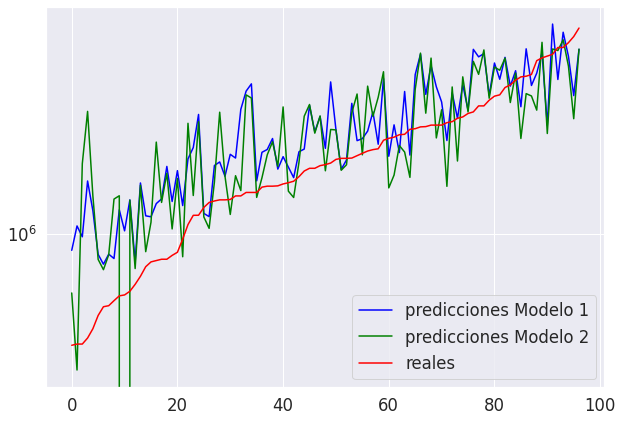

In [30]:
X = reales# np.sort(reales)
Y = pred_mod1 #np.sort(pred_mod1)#pred_mod1 #np.sort(predMod)
Z = pred_mod2
#print(Y)

#plt.figure()
fig, ax = plt.subplots(figsize=(10,7))
ax.set_xlabel('Samples', fontsize=15)
ax.set_ylabel('Precio (log)', fontsize=15)

plt.plot(np.arange(len(X)), Y, color='blue', label = 'predicciones Modelo 1')
plt.plot(np.arange(len(X)), Z, color='green', label = 'predicciones Modelo 2')
plt.plot(np.arange(len(X)), X, color='red', label = 'reales')
plt.legend()
plt.yscale('log')


#plt.show()
plt.savefig('../../Images/model1_vs_model2.png')

## Modelo 1 vs Modelo 3

In [23]:
from feats import newfeats
order_df = df_test.copy()
order_df = order_df[:100]
order_df = order_df.sort_values('precio')

order_df = order_df[['metroscubiertos', 'metrostotales', 'provincia', 'banos', 'urbana', 'calurosa', 'precio']].dropna()
reales = order_df['precio']
pred_mod1 = model1.predict(order_df)
order_df['pred_mod1'] = pred_mod1
pred_mod2 = model3.predict(order_df)
order_df['pred_mod2'] = pred_mod2

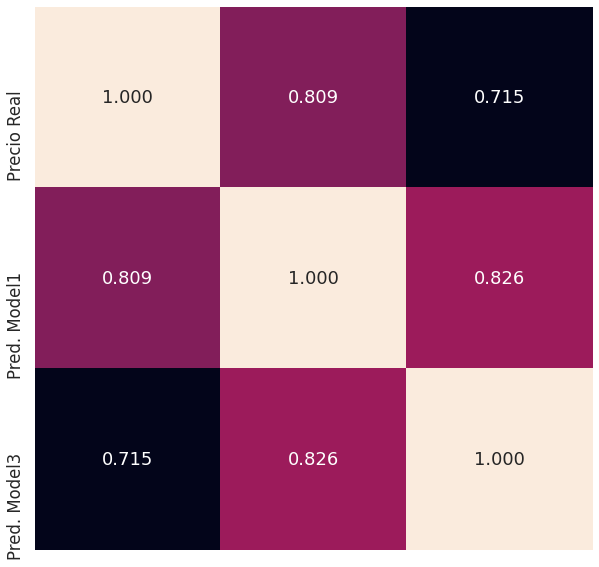

In [24]:
cm = np.corrcoef(order_df[['precio', 'pred_mod1', 'pred_mod2']].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm,
                annot=True,
                cbar=False,
                fmt='.3f',
                yticklabels=['Precio Real', 'Pred. Model1', 'Pred. Model3'],
                xticklabels=['', '', ''],
                ax=ax)
plt.savefig('../../Images/model1_vs_model3.png')

## Correlación del NLP feature

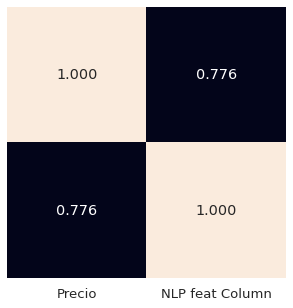

In [246]:
cm = np.corrcoef(nlpModel.df[['precio', 'nlp_feat_column']].dropna().values.T)
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(5,5))
hm = sns.heatmap(cm,
                annot=True,
                cbar=False,
                fmt='.3f',
                yticklabels=['', ''],
                xticklabels=['Precio', 'NLP feat Column'],
                ax=ax)
plt.savefig('../../Images/nlp_correlacion_precios.png')

## NLP Modelo 1 vs NLP Modelo 2

In [17]:
from feats import newfeats
order_df = df_test.copy()
order_df = order_df[:100]
order_df = order_df.sort_values('precio')

order_df = order_df[['metroscubiertos', 'metrostotales', 'provincia', 'banos', 'urbana', 'mejorciudad', 'precio'] + ['titulo', 'descripcion']].dropna()
reales = order_df['precio']
pred_mod1 = nlpModel.predict(order_df)
order_df['pred_mod1'] = pred_mod1
pred_mod2 = nlpModel2.predict(order_df)
order_df['pred_mod2'] = pred_mod2

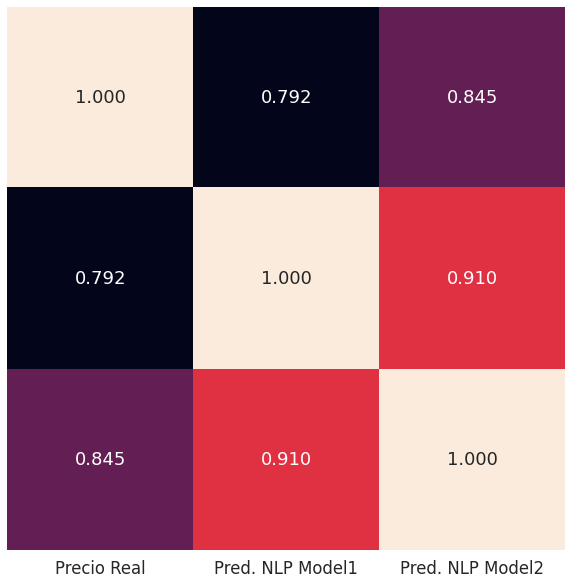

In [22]:
cm = np.corrcoef(order_df[['precio', 'pred_mod1', 'pred_mod2']].values.T)
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm,
                annot=True,
                cbar=False,
                fmt='.3f',
                yticklabels=['', '', ''],
                xticklabels=['Precio Real', 'Pred. NLP Model1', 'Pred. NLP Model2'],
                ax=ax)
plt.savefig('../../Images/nlpmodel1_vs_nlpmodel2.png')